In [1]:
import matplotlib.pyplot as plt

import numpy as np
import densmap as dm
from matplotlib import cm
import scipy.optimize as opt

In [2]:
# Function for detecting the interface
def detect_interface(darray,z0,nwin=10):
    i0 = np.abs(z-z0).argmin()
    imax = Nz-i0+1
    branch = np.zeros((2,imax-i0),dtype=float)
    for j in range(i0, imax) :
        branch[1,j-i0] = z_fold[j]
        dtar = 0.5*max(np.mean(darray[:nwin,j]),np.mean(darray[-nwin:,j]))
        for i in range(1,Nx//2) :
            if darray[i,j] > dtar and darray[i-1,j] < dtar or darray[i,j] < dtar and darray[i-1,j] > dtar :
                branch[0,j-i0] = ((darray[i,j]-dtar)*x[i-1]+(dtar-darray[i-1,j])*x[i])/(darray[i,j]-darray[i-1,j])
                break
    return branch

In [3]:
def arccot(x) :
    return 0.5*np.pi-np.arctan(x)

In [4]:
FP = dm.fitting_parameters( par_file='parameters_amorphous_friction.txt' )
file_root = 'flow'

[densmap] Initializing fitting parameters data structure


In [5]:
""" Reading input """
folder_name = FP.folder_name
Lx = FP.lenght_x
Lz = FP.lenght_z
n_init = FP.first_stamp
n_fin = FP.last_stamp
dt = FP.time_step

In [6]:
""" Creating meshgrid """
density_array = dm.read_density_file(folder_name+'/'+file_root+'_{:05d}'.format(n_init)+'.dat', bin='y')
Nx = density_array.shape[0]
Nz = density_array.shape[1]
hx = Lx/Nx
hz = Lz/Nz
x = hx*np.arange(0.0,Nx,1.0, dtype=float)+0.5*hx
z = hz*np.arange(0.0,Nz,1.0, dtype=float)+0.5*hz
X, Z = np.meshgrid(x, z, sparse=False, indexing='ij')
ihalf = (Nx//2)+(Nx%2)
density_array_sol_avg = np.zeros_like(density_array)

In [7]:
x_fold = hx*np.arange(0.0,Nx//2,1.0, dtype=float)+0.5*hx
z_fold = z
X_fold, Z_fold = np.meshgrid(x_fold, z_fold, sparse=False, indexing='ij')

In [8]:
n_dump = 10

for idx in range(n_init, n_fin+1 ):
    
    if idx%n_dump==0 :
        print("Obtainig frame "+str(idx))
        t_label = str(dt*idx)+' ps'

    density_array = dm.read_density_file(folder_name+'/'+file_root+'_{:05d}'.format(idx)+'.dat', bin='y')
    
    density_x = np.mean(density_array,axis=1)
    xcom = np.sum(density_x*x)/np.sum(density_x)
    icom = int(np.round(xcom/hx))
    ishift = ihalf-icom
    
    density_array = np.roll(density_array, ishift, axis=0)
    density_array_sol_avg += density_array
    
density_array_sol_avg /= (n_fin-n_init+1)

Obtainig frame 870
Obtainig frame 880
Obtainig frame 890
Obtainig frame 900
Obtainig frame 910
Obtainig frame 920
Obtainig frame 930
Obtainig frame 940
Obtainig frame 950
Obtainig frame 960
Obtainig frame 970
Obtainig frame 980
Obtainig frame 990
Obtainig frame 1000
Obtainig frame 1010
Obtainig frame 1020
Obtainig frame 1030
Obtainig frame 1040
Obtainig frame 1050
Obtainig frame 1060
Obtainig frame 1070
Obtainig frame 1080
Obtainig frame 1090
Obtainig frame 1100
Obtainig frame 1110
Obtainig frame 1120
Obtainig frame 1130
Obtainig frame 1140
Obtainig frame 1150
Obtainig frame 1160
Obtainig frame 1170
Obtainig frame 1180
Obtainig frame 1190
Obtainig frame 1200
Obtainig frame 1210
Obtainig frame 1220
Obtainig frame 1230
Obtainig frame 1240
Obtainig frame 1250
Obtainig frame 1260
Obtainig frame 1270
Obtainig frame 1280
Obtainig frame 1290
Obtainig frame 1300
Obtainig frame 1310
Obtainig frame 1320
Obtainig frame 1330
Obtainig frame 1340
Obtainig frame 1350
Obtainig frame 1360
Obtainig fram

<IPython.core.display.Javascript object>


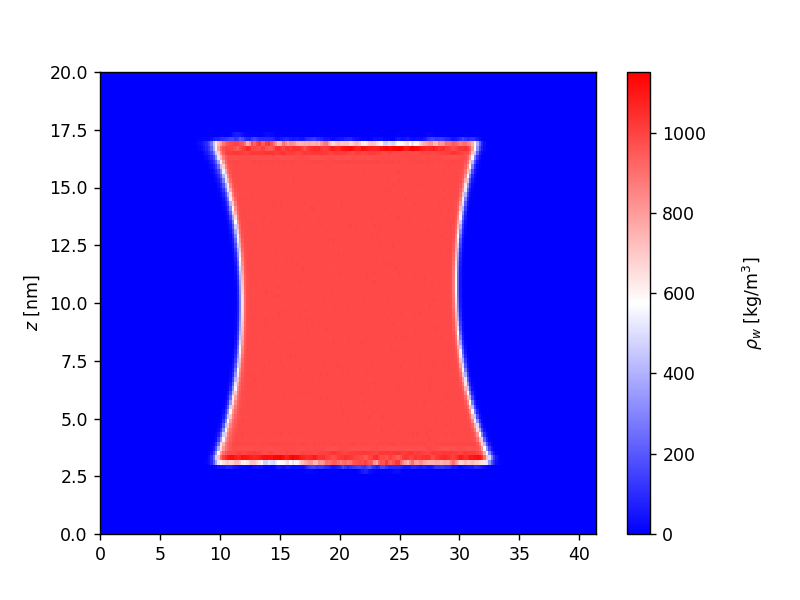

In [9]:
%matplotlib notebook

fig, ax1 = plt.subplots(1, 1, sharex=True)

dmap1 = ax1.pcolormesh(X, Z, 1.66054*density_array_sol_avg, cmap=cm.bwr)
ax1.tick_params(axis='both')
ax1.set_ylabel(r'$z$ [nm]')
cb1 = plt.colorbar(dmap1,ax=ax1)
cb1.set_label(r'$\rho_w$ [kg/m$^3$]', labelpad=20)

plt.show()

In [10]:
z0_ref = 3.5
i_local_ca = 5
density_array_sol_avglr = 0.5*(density_array_sol_avg[:Nx//2,:]+
                               np.flipud(np.fliplr(density_array_sol_avg[-Nx//2+1:,:])))
branch_sol = detect_interface(density_array_sol_avglr,z0=z0_ref)

<IPython.core.display.Javascript object>


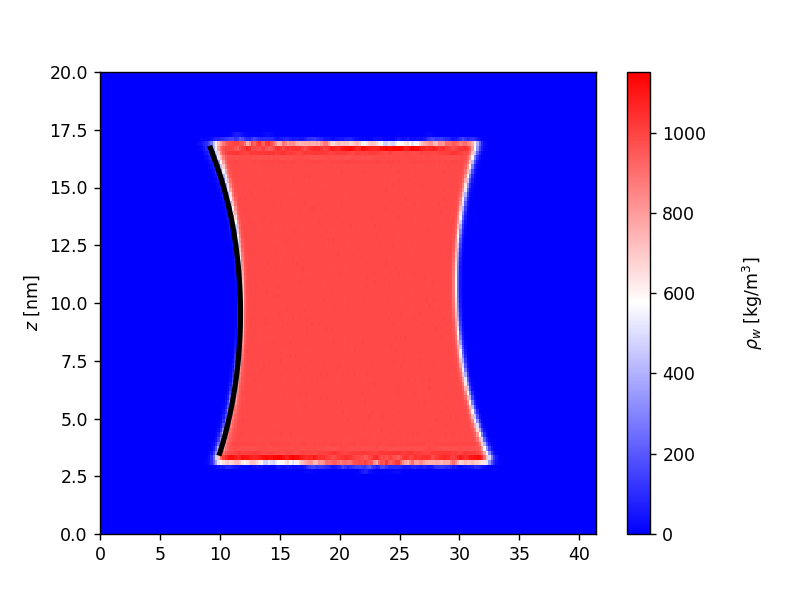

In [11]:
%matplotlib notebook

fig, ax1 = plt.subplots(1, 1, sharex=True)

dmap1 = ax1.pcolormesh(X, Z, 1.66054*density_array_sol_avg, cmap=cm.bwr)
ax1.plot(branch_sol[0,:], branch_sol[1,:],'k-',linewidth=3)
ax1.tick_params(axis='both')
ax1.set_ylabel(r'$z$ [nm]')
cb1 = plt.colorbar(dmap1,ax=ax1)
cb1.set_label(r'$\rho_w$ [kg/m$^3$]', labelpad=20)

plt.show()

In [31]:
# TANGENT-BASED
"""
npoint = len(branch_sol[0,:])
m_sol = []
m_sol.append(np.polyfit(branch_sol[0,:3],branch_sol[1,:3],deg=1)[0])
for i in range(1,npoint-1) :
    m_sol.append(np.polyfit(branch_sol[0,i-1:i+2],branch_sol[1,i-1:i+2],deg=1)[0])
m_sol.append(np.polyfit(branch_sol[0,-3:],branch_sol[1,-3:],deg=1)[0])
m_sol = np.array(m_sol)
theta_sol = np.abs(np.rad2deg(np.arctan(m_sol)))
"""

'\nnpoint = len(branch_sol[0,:])\nm_sol = []\nm_sol.append(np.polyfit(branch_sol[0,:3],branch_sol[1,:3],deg=1)[0])\nfor i in range(1,npoint-1) :\n    m_sol.append(np.polyfit(branch_sol[0,i-1:i+2],branch_sol[1,i-1:i+2],deg=1)[0])\nm_sol.append(np.polyfit(branch_sol[0,-3:],branch_sol[1,-3:],deg=1)[0])\nm_sol = np.array(m_sol)\ntheta_sol = np.abs(np.rad2deg(np.arctan(m_sol)))\n'

In [32]:
# COTANGENT-BASED
npoint = len(branch_sol[0,:])
m_sol = []
m_sol.append(np.polyfit(branch_sol[1,:3],branch_sol[0,:3],deg=1)[0])
for i in range(1,npoint-1) :
    m_sol.append(np.polyfit(branch_sol[1,i-1:i+2],branch_sol[0,i-1:i+2],deg=1)[0])
m_sol.append(np.polyfit(branch_sol[1,-3:],branch_sol[0,-3:],deg=1)[0])
m_sol = np.array(m_sol)
theta_sol = np.rad2deg(arccot(m_sol))

In [33]:
""" FOR THE EQULIBRIUM CONTACT ANGLE """
# peq = np.polyfit(branch_sol[1,:],theta_sol,deg=1,full=False,cov=True)

' FOR THE EQULIBRIUM CONTACT ANGLE '

<IPython.core.display.Javascript object>


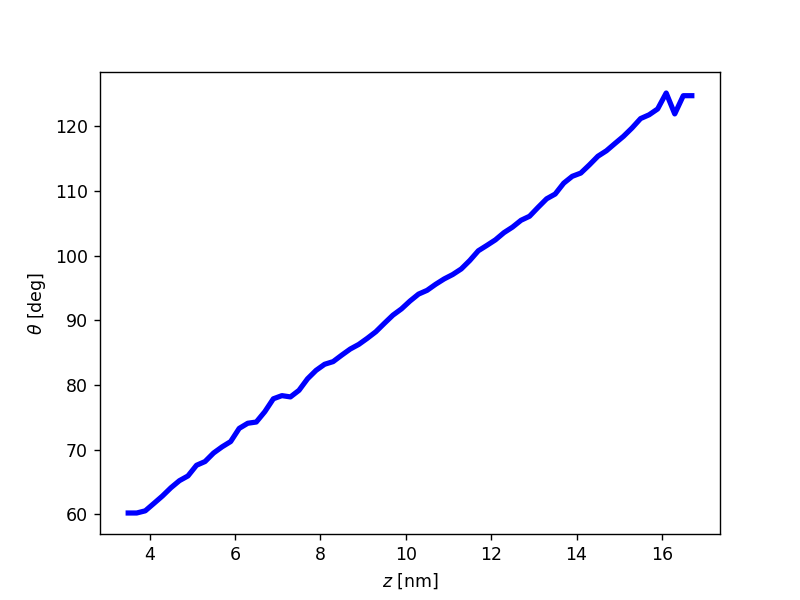

In [34]:
%matplotlib notebook

plt.plot(branch_sol[1,:],theta_sol,'b-',linewidth=3)
plt.ylabel(r'$\theta$ [deg]')
plt.xlabel(r'$z$ [nm]')

plt.show()

In [35]:
x_ca_sol_bot = branch_sol[0,:i_local_ca]
z_ca_sol_bot = branch_sol[1,:i_local_ca]
x_ca_sol_top = branch_sol[0,-i_local_ca:]
z_ca_sol_top = branch_sol[1,-i_local_ca:]

In [36]:
# TANGENT-BASED
"""
coeff_sol_bot, cov_sol_bot = np.polyfit(x_ca_sol_bot,z_ca_sol_bot,deg=1,full=False,cov=True)
coeff_sol_top, cov_sol_top = np.polyfit(x_ca_sol_top,z_ca_sol_top,deg=1,full=False,cov=True)
slope_sol_bot = coeff_sol_bot[0]
slope_sol_top = coeff_sol_top[0]
dslope_sol_bot = np.sqrt(cov_sol_bot[0][0])
dslope_sol_top = np.sqrt(cov_sol_top[0][0])

theta_sol_bot = np.rad2deg(np.arctan(slope_sol_bot))
dtheta_sol_bot = 0.5*np.abs(np.rad2deg(np.arctan(slope_sol_bot+dslope_sol_bot))-
                            np.rad2deg(np.arctan(slope_sol_bot-dslope_sol_bot)))
print("theta_sol_bot="+str(theta_sol_bot)+'+/'+str(dtheta_sol_bot))

theta_sol_top = 180-np.rad2deg(np.arctan(slope_sol_top))
dtheta_sol_top = 0.5*np.abs(np.rad2deg(np.arctan(slope_sol_top+dslope_sol_top))-
                            np.rad2deg(np.arctan(slope_sol_top-dslope_sol_top)))
print("theta_sol_top="+str(theta_sol_top)+'+/'+str(dtheta_sol_top))
"""

'\ncoeff_sol_bot, cov_sol_bot = np.polyfit(x_ca_sol_bot,z_ca_sol_bot,deg=1,full=False,cov=True)\ncoeff_sol_top, cov_sol_top = np.polyfit(x_ca_sol_top,z_ca_sol_top,deg=1,full=False,cov=True)\nslope_sol_bot = coeff_sol_bot[0]\nslope_sol_top = coeff_sol_top[0]\ndslope_sol_bot = np.sqrt(cov_sol_bot[0][0])\ndslope_sol_top = np.sqrt(cov_sol_top[0][0])\n\ntheta_sol_bot = np.rad2deg(np.arctan(slope_sol_bot))\ndtheta_sol_bot = 0.5*np.abs(np.rad2deg(np.arctan(slope_sol_bot+dslope_sol_bot))-\n                            np.rad2deg(np.arctan(slope_sol_bot-dslope_sol_bot)))\nprint("theta_sol_bot="+str(theta_sol_bot)+\'+/\'+str(dtheta_sol_bot))\n\ntheta_sol_top = 180-np.rad2deg(np.arctan(slope_sol_top))\ndtheta_sol_top = 0.5*np.abs(np.rad2deg(np.arctan(slope_sol_top+dslope_sol_top))-\n                            np.rad2deg(np.arctan(slope_sol_top-dslope_sol_top)))\nprint("theta_sol_top="+str(theta_sol_top)+\'+/\'+str(dtheta_sol_top))\n'

In [37]:
# COTANGENT-BASED
coeff_sol_bot, cov_sol_bot = np.polyfit(z_ca_sol_bot,x_ca_sol_bot,deg=1,full=False,cov=True)
coeff_sol_top, cov_sol_top = np.polyfit(z_ca_sol_top,x_ca_sol_top,deg=1,full=False,cov=True)
slope_sol_bot = coeff_sol_bot[0]
slope_sol_top = coeff_sol_top[0]
dslope_sol_bot = np.sqrt(cov_sol_bot[0][0])
dslope_sol_top = np.sqrt(cov_sol_top[0][0])

theta_sol_bot = np.rad2deg(arccot(slope_sol_bot))
dtheta_sol_bot = 0.5*np.abs(np.rad2deg(arccot(slope_sol_bot+dslope_sol_bot))-
                            np.rad2deg(arccot(slope_sol_bot-dslope_sol_bot)))
print("theta_sol_bot="+str(theta_sol_bot)+'+/'+str(dtheta_sol_bot))

theta_sol_top = 180-np.rad2deg(arccot(slope_sol_top))
dtheta_sol_top = 0.5*np.abs(np.rad2deg(arccot(slope_sol_top+dslope_sol_top))-
                            np.rad2deg(arccot(slope_sol_top-dslope_sol_top)))
print("theta_sol_top="+str(theta_sol_top)+'+/'+str(dtheta_sol_top))

theta_sol_bot=60.86398894978068+/0.32060533762327736
theta_sol_top=55.62278613454741+/1.1410353862065605


<IPython.core.display.Javascript object>


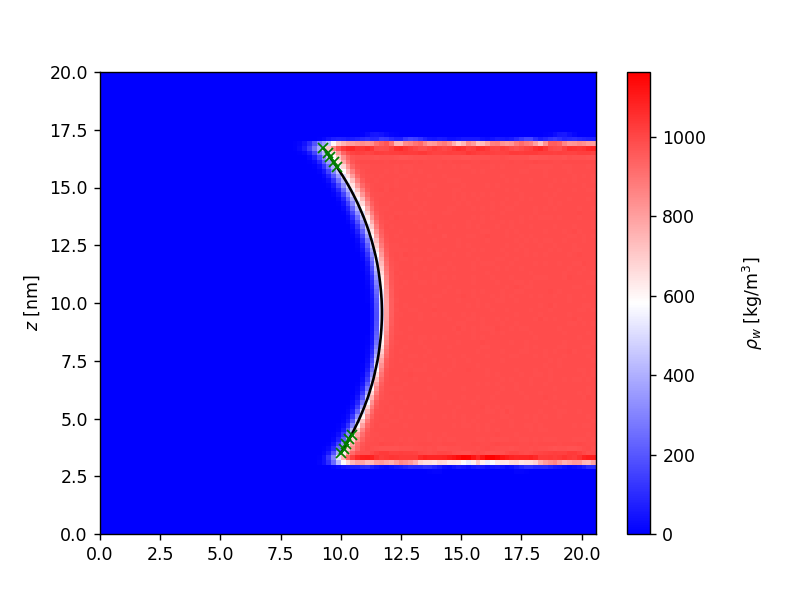

In [38]:
%matplotlib notebook

fig, ax1 = plt.subplots(1, 1, sharex=True)

dmap1 = ax1.pcolormesh(X_fold, Z_fold, 1.66054*density_array_sol_avglr, cmap=cm.bwr)
ax1.plot(branch_sol[0,:],branch_sol[1,:],'k-')
ax1.plot(branch_sol[0,:i_local_ca],branch_sol[1,:i_local_ca],'gx')
ax1.plot(branch_sol[0,-i_local_ca:],branch_sol[1,-i_local_ca:],'gx')
ax1.tick_params(axis='both')
ax1.set_ylabel(r'$z$ [nm]')
cb1 = plt.colorbar(dmap1,ax=ax1)
cb1.set_label(r'$\rho_w$ [kg/m$^3$]', labelpad=20)

plt.show()

In [2]:
# PLOTTING FINAL RESULTS FOR ALL SIMULATIONS
capillary_number = np.array(
                   [0.03,
                    0.04,
                    0.05,
                    0.06])
theta_receding   = [48.41678026787147,
                    43.03421004751277,
                    40.78034340784733,
                    38.52666505382581]
dtheta_receding  = [0.8217126510517261,
                    0.04737172902132869,
                    0.12627365855469108,
                    1.040312669246628]
theta_advancing  = [65.45496706801552,
                    66.66764755477378,
                    68.79969133896661,
                    71.24979143540405]
dtheta_advancing = [2.593313618852065,
                    0.2706755158390024,
                    0.46518791901501544,
                    1.3708156908433224]
theta_0          =  55.6
dtheta_0         =  1.1

In [3]:
gamma = 5.19e-2
U0 = 3.72463768115942
Ucl = U0*capillary_number/0.1
print(Ucl)

[1.1173913  1.48985507 1.86231884 2.23478261]


In [4]:
cos_eq = np.cos(np.deg2rad(theta_0))
sin_eq = np.sin(np.deg2rad(theta_0))

cos_adv = np.cos(np.deg2rad(theta_advancing))
cos_adv = np.concatenate((cos_eq,cos_adv),axis=None)
sin_adv = np.sin(np.deg2rad(theta_advancing))
sin_adv = np.concatenate((sin_eq,sin_adv),axis=None)
ucl_adv = np.concatenate((0,Ucl),axis=None)

cos_rec = np.cos(np.deg2rad(theta_receding))
cos_rec = np.concatenate((cos_rec,cos_eq),axis=None)
sin_rec = np.sin(np.deg2rad(theta_receding))
sin_rec = np.concatenate((sin_rec,sin_eq),axis=None)
ucl_rec = np.concatenate((-Ucl,0),axis=None)

In [5]:
pfit_adv, cfit_adv = np.polyfit(cos_adv,ucl_adv,deg=1,full=False,cov=True)
pfit_rec, cfit_rec = np.polyfit(cos_rec,ucl_rec,deg=1,full=False,cov=True)
# PF_MD = 2*np.sqrt(2)/3
# pfit_adv, cfit_adv = np.polyfit(cos_adv,PF_MD*sin_adv*ucl_adv,deg=1,full=False,cov=True)
# pfit_rec, cfit_rec = np.polyfit(cos_rec,PF_MD*sin_rec*ucl_rec,deg=1,full=False,cov=True)

In [6]:
mu_f_adv = -gamma/pfit_adv[0]
ptmp = -gamma/(pfit_adv[0]+np.sqrt(cfit_adv[0][0]))
mtmp = -gamma/(pfit_adv[0]-np.sqrt(cfit_adv[0][0]))
dmu_f_adv = 0.5*(ptmp-mtmp)

print(1e3*mu_f_adv)
print(1e3*dmu_f_adv)

mu_f_rec = -gamma/pfit_rec[0]
ptmp = -gamma/(pfit_rec[0]+np.sqrt(cfit_rec[0][0]))
mtmp = -gamma/(pfit_rec[0]-np.sqrt(cfit_rec[0][0]))
dmu_f_rec = 0.5*(ptmp-mtmp)

print(1e3*mu_f_rec)
print(1e3*dmu_f_rec)

5.659896689453016
0.4248684389875847
5.336414300383209
0.40983564395768435


<IPython.core.display.Javascript object>


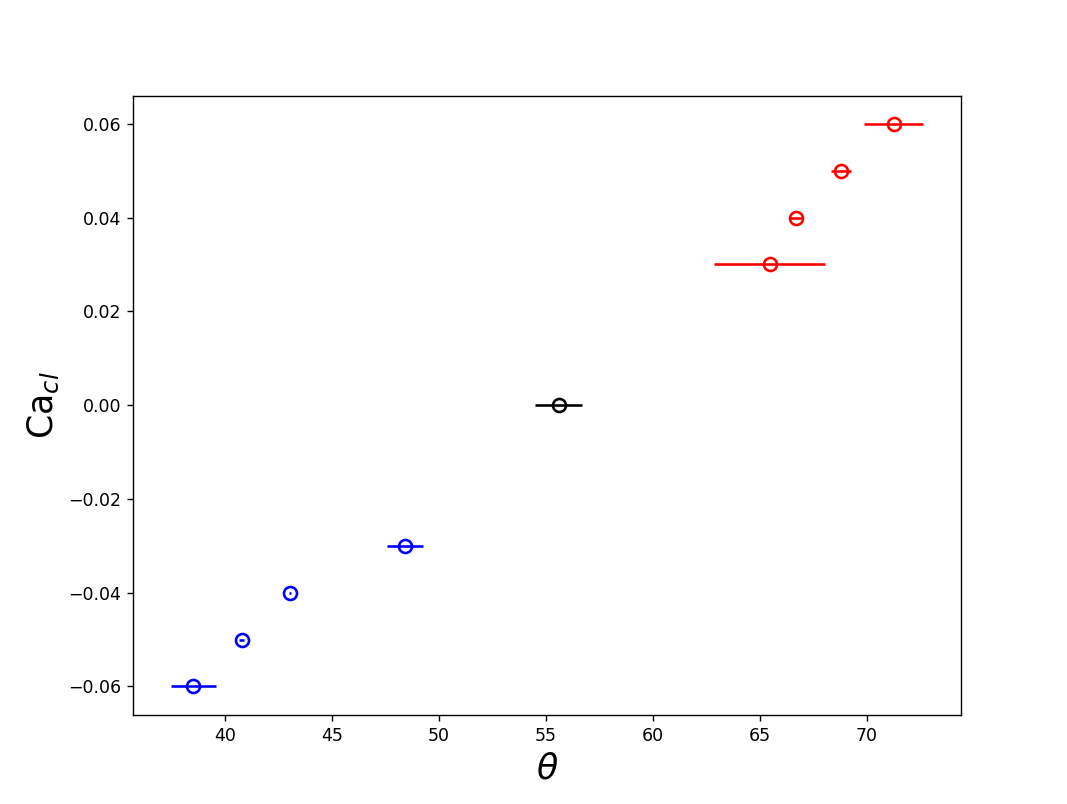

In [9]:
%matplotlib notebook

plt.errorbar(theta_advancing,capillary_number,xerr=dtheta_advancing,
             marker='o',mfc='None',mec='red',ms=7.5,mew=1.5,ls='None',ecolor='r')

plt.errorbar(theta_receding,-capillary_number,xerr=dtheta_receding,
             marker='o',mfc='None',mec='blue',ms=7.5,mew=1.5,ls='None',ecolor='b')

plt.errorbar(theta_0,0,xerr=dtheta_0,
             marker='o',mfc='None',mec='black',ms=7.5,mew=1.5,ls='None',ecolor='k')
plt.xlabel(r'$\theta$',fontsize=20)
plt.ylabel(r'Ca$_{cl}$',fontsize=20)

plt.show()

In [12]:
5.659896689453016/0.69

8.202748825294227